In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tnrange
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
batch_size = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Data Load

In [4]:
trfs = transforms.Compose([
    transforms.ToTensor()
])
dataset_train = torchvision.datasets.MNIST('./data', train=True, download=True, transform=trfs)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_test = torchvision.datasets.MNIST('./data', train=False, download=True, transform=trfs)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

len(dataset_train), len(dataset_test)

(60000, 10000)

In [5]:
def plot_batch(x_batch, y_batch):
    plt.figure(figsize=(6, 6))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.title(y_batch[i].numpy())
        image = x_batch[i].squeeze().numpy()
        plt.imshow(image, cmap='gray')
    plt.tight_layout()

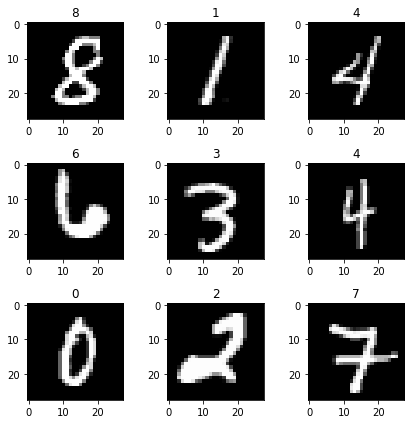

In [6]:
x_batch, y_batch = next(iter(dataloader_train))
plot_batch(x_batch, y_batch)

### Model

In [7]:
class NNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10),
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x):
        x = x.view(-1, 784)
        y = self.model(x)
        return y

### Training


CPU times: user 2min 35s, sys: 5.33 s, total: 2min 40s
Wall time: 2min 42s


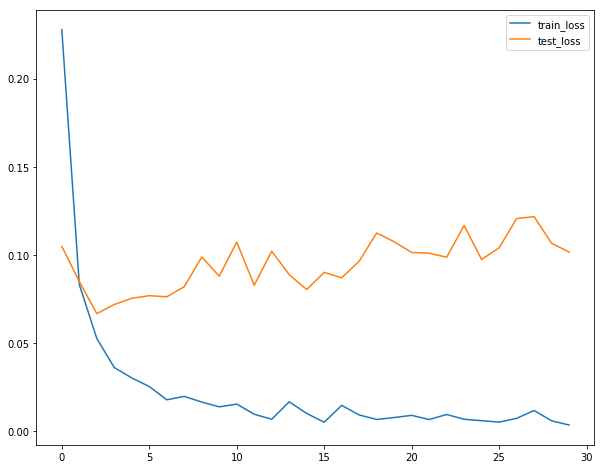

In [8]:
%%time
n_epochs = 30
lr = 1e-3

model = NNClassifier().to(device)

optimizer = optim.Adam(model.parameters(), lr = lr)
criterion = nn.NLLLoss()
train_loss_hist = []
test_loss_hist = []

with tnrange(n_epochs) as t:
    for e in t:
        t.set_description(f'Epoch {e+1}/{n_epochs}')
        train_loss = 0.
        test_loss = 0.
        acc = 0.
        model.train()
        for inputs, targets in dataloader_train:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        
            train_loss += loss.item() * inputs.size(0)
        
        # End of epoch training
        model.eval()
        with torch.no_grad():
            for inputs, targets in dataloader_test:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                test_loss += loss.item() * inputs.size(0)
        
        train_loss /= len(dataset_train)
        test_loss /= len(dataset_test)
        t.set_postfix(train_loss=train_loss, test_loss=test_loss)
        
        train_loss_hist.append(train_loss)
        test_loss_hist.append(test_loss)

plt.figure(figsize=(10, 8))
plt.plot(range(n_epochs), train_loss_hist, label='train_loss')
plt.plot(range(n_epochs), test_loss_hist, label='test_loss')
plt.legend()

### Accuracy

In [9]:
model.eval()
acc = 0.
test_loss = 0.
with torch.no_grad():
    for inputs, targets in dataloader_test:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1, keepdim=True)
        corrects = preds.eq(targets.view_as(preds)).sum().item()
        acc += corrects
        test_loss += F.nll_loss(outputs, targets, reduction='sum').item()
        
test_loss /= len(dataset_test)
acc /= len(dataset_test)
print(f'{acc:.2%} - {test_loss:.2f}')

98.48% - 0.10


### Evaluate dataset sizes

In [10]:
def train(dataset_percent=1.):
    
    indices = np.random.choice(len(dataset_train), int(len(dataset_train) * dataset_percent), replace=False)
    subds = torch.utils.data.Subset(dataset_train, indices)
    subdl = torch.utils.data.DataLoader(subds, batch_size=batch_size, shuffle=True)
    
    n_epochs = 30
    lr = 1e-3

    model = NNClassifier().to(device)

    optimizer = optim.Adam(model.parameters(), lr = lr)
    criterion = nn.NLLLoss()
    
    with tnrange(n_epochs) as t:
        t.set_description(f'Dataset {len(subds)}')
        for e in t:
            for inputs, targets in subdl:
                inputs, targets = inputs.to(device), targets.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()


    # End of training
    model.eval()
    acc = 0.
    test_loss = 0.
    with torch.no_grad():
        for inputs, targets in dataloader_test:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1, keepdim=True)
            corrects = preds.eq(targets.view_as(preds)).sum().item()
            acc += corrects
            test_loss += F.nll_loss(outputs, targets, reduction='sum').item()
        
    test_loss /= len(dataset_test)
    acc /= len(dataset_test)
    return test_loss, acc

In [11]:
results = [(i, *train(i)) for i in [1.0, 0.9, 0.5, 0.1, 0.01]]

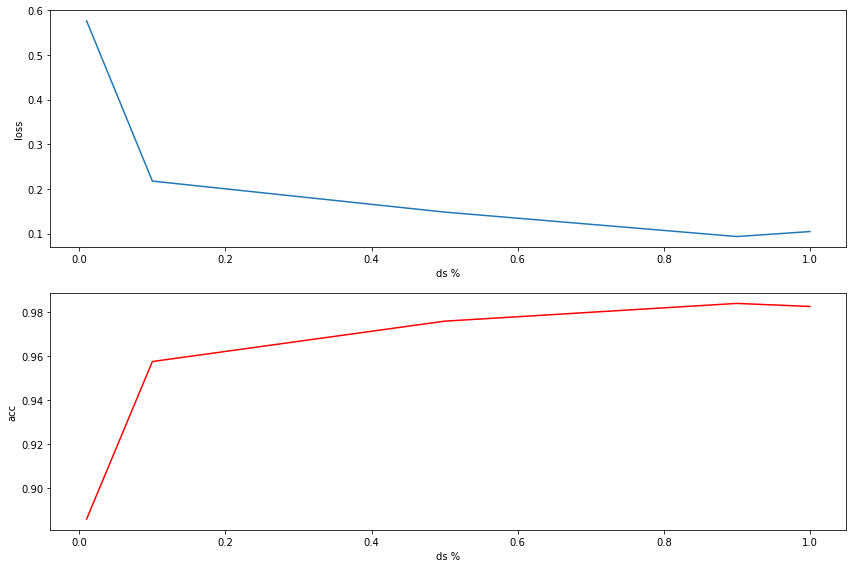

In [12]:
ds, losses, accs = zip(*results)
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(ds, losses)
plt.xlabel('ds %')
plt.ylabel('loss')
plt.subplot(2, 1, 2)
plt.plot(ds, accs, '-r')
plt.xlabel('ds %')
plt.ylabel('acc')
plt.tight_layout()

In [13]:
ds_sizes = [int(len(dataset_train) * i) for i in ds]

pd.DataFrame({
    'ds_percent': ds,
    'ds_size'   : ds_sizes,
    'losses'    : losses,
    'accs'      : accs
})

,ds_percent,ds_size,losses,accs
0,1.00,60000,0.104710,0.9827
1,0.90,54000,0.093541,0.9841
2,0.50,30000,0.148306,0.9760
3,0.10,6000,0.217777,0.9576
4,0.01,600,0.576539,0.8858
